CHE542
#### HOMEWORK 4: *Classification on a MoleculeNet Dataset* |  ChEMBL 

### *Task*
Given a Protein Receptor, Classify which compounds are significantly active and which compounds display negligible activity. 

- After Training, A Binary Classification Model Can Perform A Virtual Screen
    
Below, the physical process of screening a compound library against a protein receptor is shown. 
![Getting Started](Single_Target_AssayPNG.PNG)
A classifier trained on assay/screening data would assign compounds a label (active or inactive) instead producing physical measurements such as IC50.
 
 

The 'final result' of this notebook are binary classifiers which appear capable of performing virtual assays with an encouraging degree of accuracy. Given a Receptor has a large enough assay size (about 500 or more compounds), we can predict which compounds will display significant activity at a rate between 30 and 65 percent accuracy. In general, the active compounds comprise about 10% of the dataset, so the model strongly outperforms a random guess. At the same time, the model correctly predicts inactive compounds between 93 and 98 percent of the time, implying there are few missed opportunities in terms of active compounds going unrecognized. 

Virtual Screening, of course, is a long-established task in Cheminformatics and can be carried out in different ways, as well as at different levels of resolution. Ligand-Based Virtual Screening consider only information about the compounds (their molecular features implied via SMILES)and their inhibitory effect on the target of interest. QSAR models and Similarity Searches (2-D and 3-D)are common examples.

Structure-Based Virtual Screening, on the other hand, incorporates knowledge about the Ligand-Protein complex as well and is consequently more costly. The proposed binary classifier would be another example of a Ligand-Based VS.

##### Virtual Screening In Practice

Workflows commonly include multiple types of virtual screens used sequentially to whittle a compound library down to a handful of promising candidates.

                            
![virtual_screening-2.PNG](attachment:virtual_screening-2.PNG)


                            A) Binary Classifier, 2D Similarity Search, QSAR Models

                            B) 3D Similarity Search

                            C) Docking

                            D) FEP+

                            E) Physical Assay (Ground Truth)


While the final result of this notebook is a binary classifier,a plethora of powerful models capable of Ligand-Based Virtual Screening already exist. Instead, the central motivation largely comes from creating a *Multi-Label Classifier*.


Such a model would be different from any of the previously discussed virtual screens because it would consider activity data for compounds across multiple targets  This narrative, rather than single-target classification, is present for the first half of the notebook and culminates in the construction of a Multi-Target DataFrame where the rows are compounds and the columns are Receptors (Targets).The second half examines what happens if we train a binary classifier on individual columns (single target) from this Multi-Target DataFrame.  

##  **Motivation**

#### *Mimic Proprietary Multi-Target Datasets Using Public Data*
 

#### Example: Merck Kinase Dataset (Proprietary)
This dataset can also be accessed via deepchem's MoleculeNet. Here is how it is described in the documentation ().

"It contains 2500 Merck in-house compounds that were measured for IC50 of inhibition on 99 protein kinases. Unlike most of the other datasets featured in MoleculeNet, the Kinase collection does not have structures for the compounds tested since they were proprietary Merck compounds. However, the collection does feature pre-computed descriptors for these compounds."


Because *each* of the 2,500 compounds is assayed against *all* 99 kinases, the knowledge contained in such a dataset is remarkably informative
In the Merck Dataset, we can imagine the physical screening process is repeated over all 99 targets. For each kinase, the most active compounds (and their respective structures) can be studied in order to form a pharmacophore. If there are multiple structurally unique active compounds, the same process will produce a set of pharmacophores. Thus, for each kinase, we can use its associated pharmacophores to construct crude illustrations of known optimal binding modes. We can also extend this notion beyond a single kinase to families of kinases. For example, we can examine if any commonalities exist between all the pharmacophores in a family. The differences between pharmacophores of closely related kinases may even be leveraged to highlight which features are most specific to a kinase. Although this explorative approach remains untested, we can try to implemenent its predictive counter part. 

## *Multi-Label Classification Model*
Given a Multi-Target DataFrame (rows = Compound Library, columns = Receptor Set), we can train a multi-label classification model which can recieve an input compound and predict the kinases it will be active for. 

A Multi-Label classification model can take some input as a subject and assign which labels apply to it. For example, it could be trained on images of animals and afterwards be asked to identify which types of animals are present in any given image. Inputs may belong to one or multiple labels. Here, the image contains *both* a cat and a bird:

![Multi-Label.PNG](attachment:Multi-Label.PNG)

Because our classifier would receive a molecule as input and assign which receptors it will be active for, it would closely resemble the previous example:
![alt text](New_name.PNG "Title")


### *Receptor Families* 

Using a classifier trained on Multi-Target data is similar in spirit to studying the selectivity of a compound by assaying it against other, off-target kinases in the kinome.

For example, the kinome map below represents 500 protein receptors and 6 compounds assayed against a subset (113) of these kinases. We can compare the compounds by studying which kinases they inhibit and which they do not. Although each compound is assayed against all 113 kinases those with negligible activity are not circled in red. On the other hand, the magnitude of the circle represents the degree of inhibition. 
##### Kinome Map

![Getting Started](kinome.jpg)

###### **Some compounds such as *Valatonib* are more selective because they show activity for a small subset of targets (selective), while others (*Stuarospirine*) are active across a much wider range.**
![Getting Started](kinome_tree_selectivity.PNG)

#### Classification Model as  Analog 
We could imagine a multi-label classifier trained on the Merck dataset as a similar but virtual process in which the kinase subset size is 99 and the red circles are equal magnitude. In other words, we can only classify a compound as active or inactive. Additionally, there may be other benefits to using a predictive model on this dataset such as using feature importance to rank molecular features most relevant for potency. The biggest issue here is that the full, non-anonymized data is not publically available. The question which arises, then, is how close can we get for free? 

#### Notebook Goals
  1) *Create a Multi-Target DataFrame from a publically available source*
     
Merck's DataFrame is 2,500 rows (compounds) and 99 columns (kinases).This equals 247,500 unique compound-target activities. I have access to the ChEMBL database which includes thousands of protein receptors and hundreds of thousands of compounds. I will try to create the largest Multi-Target Dataset possible from this. Of course, we are no longer working with specifically kinases with ChEMBL, but all protein receptors.


 2)  *Create a Binary Classification Model Capable of Performing Ligand-Based Virtual Screening*

Because Multi-Label classification is harder, let's split apart our Multi-Target DataFrame into a series of single targets. If Single Label classification has very poor success, it does not make sense to try multi-label and points to issues with informative capacity of the data. Further discussion of Multi-Target Classification approaches is reserved at the end of this notebook.

# Part 1: Multi-Target DataFrame

### Load Initial ChEMBL Target Activity Data Through MoleculeNet
- Use 5thresh Subset to narrow Down Full ChEMBL dataset to Targets with 5 or more compounds assayed against them

In [6]:
chembl_tasks, datasets, transformers = dc.molnet.load_chembl(set= '5thresh',reload=False)#Multiple Comments on this line, Check associated text file 
train, valid, test = datasets # Similarly following doc. convention, and I am only interested in train for now and regard instead as my inital dataset

#### Code Chunk 0; Extract Multi-Target Data 

The output of this code chunk represents our initial multi-target DataFrame. There are 19,096 rows and 691 columns 

- Column Perspective: Each column is a protein/receptor (target) and its entries are compounds assayed against it. 

- Row Perspective: Each row is a compound and its entries are proteins assayed against it.

For compounds which have never been assayed against a target, we should expect there to be no data (NaN). However initial inspection shows that the initial matrix does not include any NaN. 

For further comments about the code, please consult the associated text file.


In [93]:
Y = pd.DataFrame(train.y)
Y.index = train.ids
for col in Y.columns: #Add Target tag to columns in Y (prevents column name ambiguity down the road) 
    Y.rename(columns={col:f"Target {col}"},inplace=True)
print(f'DataFrame shape: {Y.shape[0]} Columns, {Y.shape[1]} Rows ')
Y.head()# FIRST FIVE ROWS SHOWN

DataFrame shape: 19096 Columns, 691 Rows 


### Data Pre-Processing 

Elimimate duplicates by canonicalizing SMILES and dropping rows with identical indices to ensure rows each is a unique molecule

*We can see that the DF length remains unchanged (19,096), so we have no duplicates*

In [94]:
#Canonicalization Step
Y.index=[MolToSmiles(MolFromSmiles(compound_smiles,sanitize=False),canonical=True) for compound_smiles in Y.index]
# Dropping Duplicate Indices Step
Y.reset_index().drop_duplicates(subset='index', keep='last').set_index('index').shape

(19096, 691)

# **Inital Exploration**


We have 691 columns (Targets/Receptors), where each column has 19,096 entries. Of course, not all of the 19,096 compounds will have activity data for the Target. In fact, we would expect most entries to be NaN for any given target. 

Therefore, for each Target we must filter out the set of compounds it was not assayed against.   

##### Examining a Single Target

In [95]:
Single_Target = pd.DataFrame(Y['Target 237'])
Single_Target

,Target 237
CC(NC(C)(C)C)C(=O)c1ccc(Br)cc1,-0.328485
CC#CCOc1ccc(S(=O)(=O)C(CCCCCC)C(=O)NO)cc1,-0.328485
NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,2.747118
N#CCC(=O)Nc1ccc(S(N)(=O)=O)cc1,3.453675
CCCCCCCCOc1ccc(NC(=O)[C@@](C)(N)COP(=O)(O)O)cc1F,-0.328485
...,...
CCCCN1C(=O)C(C(=O)NC2CCCCC2)=CC2=C1CCCCCC2,-0.328485
N=C(N)c1ccc(Oc2cc(Oc3ccc(C(=N)N)cc3)cc(C(=O)Nc3ccc(F)cc3)c2)cc1,-0.328485
CN1CCN[C@H](C(=O)N[C@H](Cc2ccc(F)cc2)C(=O)N2CCC(C(=O)NC(C)(C)C)(C3CCCCC3)CC2)C1,-0.328485
CN1C2C=C(c3cccc(c4ccccc4)c3)CC1CC2,-0.328485


Although crude, plotting the activity for a single receptor (Target 237) shows the activity type may be Inhibition measured as IC50 uM because many values range between 2 and 5. 

<Axes: >

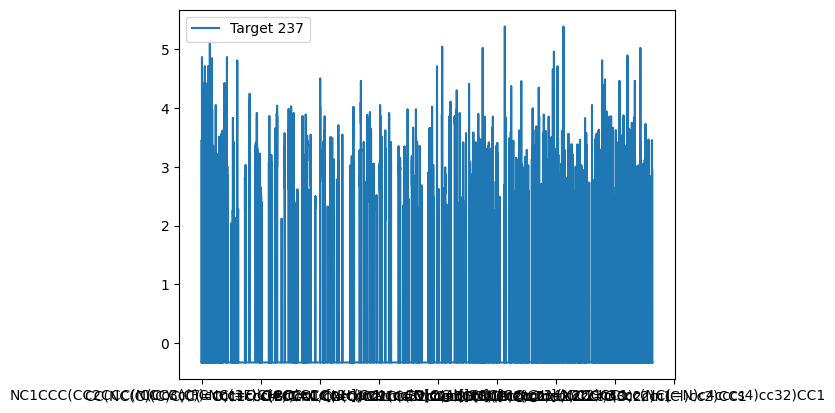

In [96]:
Single_Target.plot()

Creating a histogram reveals that a single, negative measurement occurs extremely frequently. Outside of this, the values are similar to those of Inhibition measured in uM.

This, combined with the fact that negative activity data (IC50,Ki, etc.) is logically impossible, means the single, oft-repeating negative value is likely notation for NaN.

array([[<Axes: title={'center': 'Target 237'}>]], dtype=object)

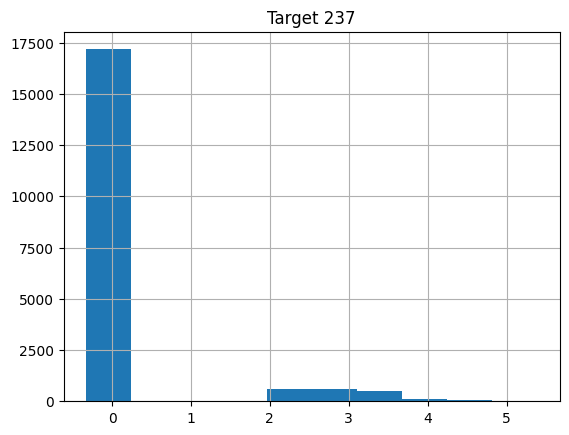

In [97]:
Single_Target.hist()

If we convert negative values to NaN and according drop rows (compounds) with NaN entries, we can access the set of assayed compounds.

In [119]:
Y[Y <= 0] 
Y[Y <= 0] = np.nan # From above discussion , negative IC50 is impossible + repeating single val likely means Nan 
Single_Target_Filtered = pd.DataFrame(Y['Target 237']).dropna() # removes NaN rows
Single_Target_Filtered

,Target 237
NS(=O)(=O)c1cc(Cl)c(Cl)c(c1)S(=O)(=O)N,2.747118
NS(=O)(=O)c1ccc(NC(=O)CC#N)cc1,3.453675
CN(C)CCN=C(S)/NCCc1ccc(cc1)S(=O)(=O)N,3.412113
CC(C)(C)OC(=O)NS(=O)(=O)NCc1ccccc1,2.295129
CCCN(CCC)S(=O)(=O)c1ccc(cc1)C(=O)N[C@@H](CC(C)C)C(=O)O,2.315910
...,...
NS(=O)(=O)c1ccc(CNC(=O)CN(CCN(CC(=O)O)CC(=O)NCc2ccc(cc2)S(=O)(=O)N)CC(=O)O)cc1,2.975710
NS(=O)(=O)c1cc(C(=O)O)c(NCc2occc2)cc1Cl,3.417308
NS(=O)(=O)c1ccc(CNC(=O)CCCNC(=O)NCCc2ccccc2)cc1,3.453675
CC1CN(C)S(=O)(=O)c2ccc(N)cc12,2.892585


Finally, if we re-create a the two graphs before, it is clear the activity data for Target 237 takes on similar values to an inhibiton assay measured in uM. 

<Axes: >

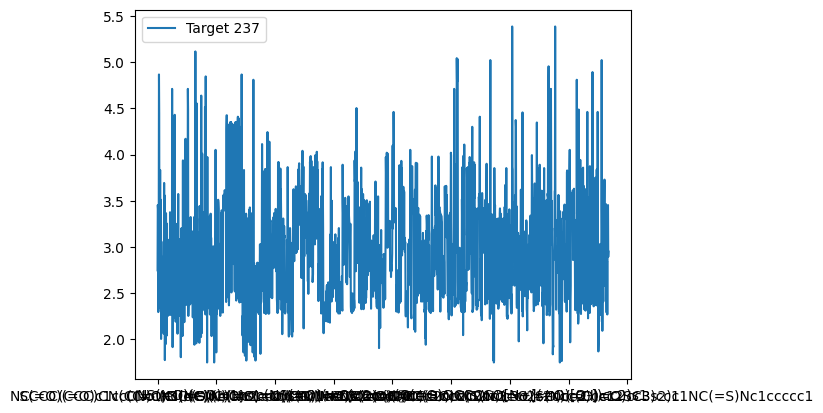

In [100]:
Single_Target_Filtered.plot()

array([[<Axes: title={'center': 'Target 237'}>]], dtype=object)

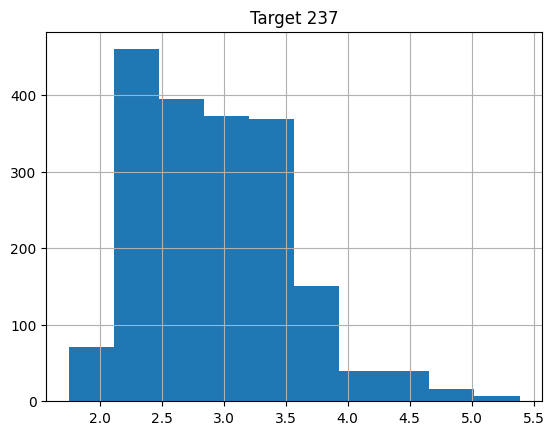

In [101]:
Single_Target_Filtered.hist()

### CODE CHUNK 1; **Sort Targets by size of Assay**

Return List where each item is a Column (Target) of varying length only containing activity.


In [102]:
Y = Y.loc[:, (Y != 0).any(axis=0)]
backup = Y.copy()
only_hits_dfs = []
for i,col in enumerate(Y):
    only_hits_dfs.append(pd.DataFrame(Y[col].dropna())
)
    

many_hits = []
for i,df in enumerate(only_hits_dfs):
    df = df[df.columns[0]]
    if len(df)>300:
        #print(len(df))
        #print(i)
        many_hits.append(df)
many_hits.sort(key=len)
many_hits.reverse()

##### We can see Target 237 is the largest with 1,921 compounds assayed against it.

In [103]:
pd.DataFrame(many_hits[0]) # This is the most commonly assayed Target.


,Target 237
NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,2.747118
N#CCC(=O)Nc1ccc(S(N)(=O)=O)cc1,3.453675
CN(C)CC/N=C(/S)NCCc1ccc(S(N)(=O)=O)cc1,3.412113
CC(C)(C)OC(=O)NS(=O)(=O)NCc1ccccc1,2.295129
CCCN(CCC)S(=O)(=O)c1ccc(C(=O)N[C@@H](CC(C)C)C(=O)O)cc1,2.315910
...,...
NS(=O)(=O)c1ccc(CNC(=O)CN(CCN(CC(=O)O)CC(=O)NCc2ccc(S(N)(=O)=O)cc2)CC(=O)O)cc1,2.975710
NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,3.417308
NS(=O)(=O)c1ccc(CNC(=O)CCCNC(=O)NCCc2ccccc2)cc1,3.453675
CC1CN(C)S(=O)(=O)c2ccc(N)cc21,2.892585


#### The 20th largest assay belongs to Target 150 with 631 compounds tested against it.

In [104]:
pd.DataFrame(many_hits[20]) # This is the most commonly assayed Target.


,Target 150
COc1cc(C[C@@H](C)N)c(OC)cc1I,6.488113
COc1cc(CC(C)N)c(OC)cc1I,5.646307
CN(C)[C@H]1Cc2ccccc2[C@H](c2ccccc2)C1,4.875974
CN(C)[C@@H]1Cc2ccccc2[C@@H](c2ccccc2)C1,5.789255
CN(C)CCc1c[nH]c2cc(O)ccc12,3.922986
...,...
N=C(N)NCCC[C@@H]1NC(=O)/C(=C/c2c[nH]c3cc(Br)ccc23)NC1=O,4.955390
Cc1ccc2c(N3CCN(CCc4cccc(N5CCNC5=O)c4)CC3)cccc2n1,4.423305
C[C@@H]1CNC[C@H]2Cc3ccc(COCC4CC4)nc3N21,6.519879
O=C1c2ccc3c(c2C[C@@H]2CNCCN12)OCCC3,5.844846


# Checkpoint Saturday Night

### Code Chunk 2; Create Largest Possible Multi-Target DataFrame

Many approaches which guarantee larger dataframes, I take the simplest aprroach. Start with the largest Target (assay size) and add the next largest assay with the highest compound overlap. With this new dataset (2 targers by x number of shared compounds) try the same thing and repeat until adding a new target loses too much data.

In [105]:


all_things = []
for J,item in enumerate(many_hits[13:15]):
    new_base=pd.DataFrame(Y[many_hits[J].name]).copy()
    end_range = len(many_hits)-2
    for i,target in enumerate(many_hits[1:end_range]):
        if i == 0:
            base = new_base.copy()
        else:
            base = merged_df
        other_hits_series = many_hits[i+1:]
        local_running_total =0
        for j,o in enumerate(other_hits_series):
            #print(o.name)
            #print(local_running_total)
            df_o = pd.DataFrame(Y[o.name]).copy()
            if len([x for x in df_o.columns.intersection(base.columns)])==0:
                #print(base.columns)
                other_merged_df = pd.merge(df_o,base,how='inner',right_index=True,left_index=True).dropna(axis=0,how='any')
                other_merged_cell_count = other_merged_df.shape[0] * other_merged_df.shape[1]
                if other_merged_cell_count > 0:
                    if other_merged_cell_count == local_running_total:
                        #print(local_running_total)
                        #print('weird tie case, rpobbaly include both which adds more data!. For now reducing to 1 (favoring newst)') 
                        pass
                if other_merged_cell_count>local_running_total:
                    local_running_total = other_merged_cell_count
                    current_merge_choice = other_merged_df
                    #print(f'{local_running_total} {i}')    
        if local_running_total==0:
            #print('no merge amongst any of the others')
            current_merge_choice = None
        else:
            if current_merge_choice is not None:
                #print(i)
                #print(base.columns)
                #print(current_merge_choice.columns)
                merged_df_cell_count = current_merge_choice.shape[0]*current_merge_choice.shape[1]
                base_cell_count = base.shape[0]*base.shape[1]     
                if (merged_df_cell_count>base_cell_count) and (i>0):
                    #print(f'Running Total Cell Count: {base_cell_count}... Current Total: {merged_df_cell_count}')
                    merged_df = current_merge_choice
                elif i == 0:
                    #print(f'Starting Total Cell Count: {base_cell_count}... Current Total: {merged_df_cell_count}')
                    merged_df = current_merge_choice
                else:
                    merged_df = base
            else:
                merged_df = base
    if len(merged_df)>1:
        print('yes')
        all_things.append(merged_df)

all_things.sort(key=len)
all_things.reverse()
all_things[-1]

yes
yes


,Target 354,Target 410,Target 117,Target 237
NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,3.299619,3.203899,3.135286,2.747118
N#CCC(=O)Nc1ccc(S(N)(=O)=O)cc1,4.220268,3.675802,3.504011,3.453675
CC(F)CNc1ccc(S(N)(=O)=O)cc1,3.215924,3.232791,3.051273,3.183521
COC(=O)/C=C/c1ccc(O)cc1,2.703905,2.611614,2.519189,2.845828
C=C(C)CNS(=O)(=O)c1ccc(N)cc1,2.605440,2.317879,2.159799,2.347081
...,...,...,...,...
NS(=O)(=O)c1ccc(CNC(=O)CN(CCN(CC(=O)O)CC(=O)NCc2ccc(S(N)(=O)=O)cc2)CC(=O)O)cc1,3.900257,3.608387,3.896073,2.975710
NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,2.945144,2.760889,3.027936,3.417308
NS(=O)(=O)c1ccc(CNC(=O)CCCNC(=O)NCCc2ccccc2)cc1,3.329159,2.828304,3.480674,3.453675
CC1CN(C)S(=O)(=O)c2ccc(N)cc21,2.920528,2.996840,2.645209,2.892585


In [118]:
 1204*4

4816

### *How Much Information Does The Largest Multi-Target DataFrame Contain?*
The DataFrame contains 1,204 unique compounds (rows) assayed against four unique targets (columns) or equivantly 4,816 entries (individual IC50 measurements). 

We can see this is about 50x smaller than the Merck Kinase Dataset! 
- Merck Multi-Target DataFrame --->2,500 compounds x 99 targets = 247,500

#### Fundamental Problem: Public-Acess Activity Data Is a Patchwork
While it is likely that there better ways to construct a larger multi-target DataFrame, it is hard to imagine that even the best approach could more than quadrouple the current size. The issue here is that public-access assay data are provided by a wide range of parties who inviariably target different receptors.One assay could come from a group wanting to target a receptor involved in cancers linked to Double-stranded DNA breaks. Another assay could be provided by a different group targeting a receptor involved in a different cancer pathway, or even a different disease entirely. 

*If two Receptors are unrelated, their assays share very little (oftentimes zero) compounds in common.*

Because of this, despite our 691 Targets, most have only a handful of compounds in common. The rows (compounds) of a Multi-Target DataFrame are equivalent to the intersection formed between the compound libraries associated with each Target's assay. For example, if three targets share 400 compounds, but a fourth target only shares 20 in common with them, then the 4-Target DataFrame formed between them only has 20 rows. 

#### Imputation and Other Strategies to Include More Data
If we relax our intersection contraints from 100% (all compounds are shared between all targets), it is much easier to construct the DataFrame and find suitable sets of Targets. While this introduces entries with unknown values (no assay for compound-target), it may be possible to approximate their values through imputation. Further discussion of imputation and other ideas aimed at increasing the maximum size of a Multi-Target DataFrame are reserved for the conclusion and remain hypothetical. 

Instead, the implemented solution leverages the patchwork nature of the ChEMBL assay data to produce a collection of large Multi-Target DataFrames. This increases the number of unique entries (compound-target activity measurement) from 4,816 to 32,000 which is about 7x smaller than Merck .  

### Breadth Approach 

We want to find find the patches. T

In [108]:
unused_hits=[df for df in many_hits if df.name not in base.columns] 
many_hits = unused_hits
new_base=merged_df = pd.DataFrame(Y[many_hits[0].name]).copy()

end_range = len(many_hits)-2
for i,target in enumerate(many_hits[1:end_range]):
    if i == 0:
        base = new_base.copy()
    else:
        base = merged_df
    other_hits_series = many_hits[i+1:]
    local_running_total =0
    for j,o in enumerate(other_hits_series):
        #print(o.name)
        #print(local_running_total)
        df_o = pd.DataFrame(Y[o.name]).copy()
        if len([x for x in df_o.columns.intersection(base.columns)])==0:
            #print(base.columns)
            other_merged_df = pd.merge(df_o,base,how='inner',right_index=True,left_index=True).dropna(axis=0,how='any')
            other_merged_cell_count = other_merged_df.shape[0] * other_merged_df.shape[1]
            if other_merged_cell_count > 0:
                if other_merged_cell_count == local_running_total:
                    #print(local_running_total)
                    #print('weird tie case, rpobbaly include both which adds more data!. For now reducing to 1 (favoring newst)') 
                    pass
            if other_merged_cell_count>local_running_total:
                local_running_total = other_merged_cell_count
                current_merge_choice = other_merged_df
                #print(f'{local_running_total} {i}')    
    if local_running_total==0:
        #print('no merge amongst any of the others')
        current_merge_choice = None
    else:
        if current_merge_choice is not None:
            #print(i)
            #print(base.columns)
            #print(current_merge_choice.columns)
            merged_df_cell_count = current_merge_choice.shape[0]*current_merge_choice.shape[1]
            base_cell_count = base.shape[0]*base.shape[1]     
            if (merged_df_cell_count>base_cell_count) and (i>0):
                print(f'Running Total Cell Count: {base_cell_count}... Current Total: {merged_df_cell_count}')
                merged_df4 = current_merge_choice
            elif i == 0:
                print(f'Starting Total Cell Count: {base_cell_count}... Current Total: {merged_df_cell_count}')
                merged_df4 = current_merge_choice
            else:
                merged_df4 = base
        else:
            merged_df4 = base



Starting Total Cell Count: 19096... Current Total: 2184


In [109]:
details = []
for i,df in enumerate(only_hits_dfs):
    if len(df)>300:
        print(len(df))
        print(i)


318
37
378
38
515
48
306
73
309
75
361
104
1904
117
859
131
1185
137
387
141
1110
146
351
147
904
148
631
150
1228
151
1500
156
424
159
371
166
450
167
1123
170
807
174
311
176
1085
177
1105
185
1072
187
746
191
346
197
1245
216
643
224
1106
225
433
233
1921
237
341
243
393
248
395
249
549
252
339
255
527
269
364
270
438
295
328
312
810
330
447
331
425
334
374
335
366
342
476
345
317
346
1560
354
561
356
405
359
404
367
531
368
475
377
350
378
463
395
1726
410
406
446
409
461
498
471
314
480
347
554
405
562


In [110]:



data_matrix_0 = data_matrix.copy()
X = data_matrix_0.iloc[:,:1024].copy()
Y = data_matrix_0.iloc[:,1024:].copy()
#dm = pd.concat([X,Ys])
cleaned_lis = []
for string in X.index:
    lis_0 = []
    for char in string:
        if char !='\\':
            lis_0.append(char)
    cleaned_lis.append(''.join(lis_0))
X.index = cleaned_lis


#dm = pd.concat([X,Ys])
cleaned_lis = []
for string in Y.index:
    lis_0 = []
    for char in string:
        if char !='\\':
            lis_0.append(char)
    cleaned_lis.append(''.join(lis_0))
Y.index = cleaned_lis


#Y[Y<=0] = np.nan

Ys =np.log10(Y)*-1

dm = pd.concat([X.copy(),Ys.copy()],axis=1)
data_matrix = dm.copy()


C:\Users\Jelan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Jelan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


In [112]:

data_matrix_practice = data_matrix.copy()
data_matrix_practice.index.name = 'SMILES'
data_matrix_practice.reset_index(inplace=True)
data_matrix_practice['SMILES']= [rdkit.Chem.MolToSmiles(rdkit.Chem.MolFromSmiles(smi)) for smi in data_matrix_practice['SMILES']]

duplicates_smiles = data_matrix_practice[data_matrix_practice['SMILES'].duplicated()]['SMILES'].values
TRUE_X = data_matrix_practice.drop_duplicates('SMILES',keep='first')
TRUE_X.index = TRUE_X['SMILES']
data_matrix = TRUE_X.drop(columns=['SMILES'])



col_name = many_hits[0].name
cols = [x for x in X.columns]
X.index = [rdkit.Chem.MolToSmiles(rdkit.Chem.MolFromSmiles(smi)) for smi in X.index]
cols.append(col_name)
single_classifier_dm = data_matrix[cols]
DM = single_classifier_dm.dropna(axis=0,subset=col_name)
print(DM.shape)

continous_value_DM = DM.copy()
activity_threshold = np.percentile(continous_value_DM.loc[:,col_name], 90)
inds = DM[col_name]<activity_threshold
inds_a = DM[col_name]>=activity_threshold
DM = DM.copy()
DM.loc[inds,col_name]=0
DM.loc[inds_a,col_name]=1
DM.shape


(1499, 1025)


(1499, 1025)

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

<Axes: >

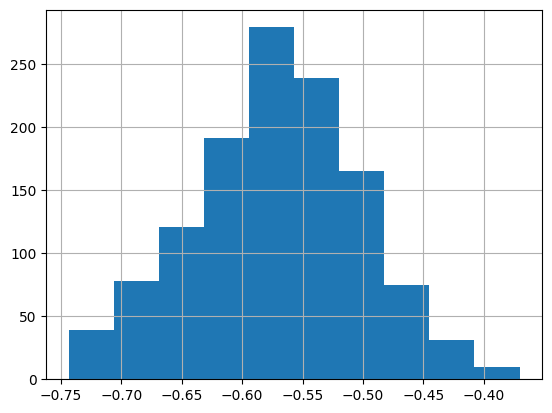

In [114]:
Ys['Target 151'].hist()

# Machine Learning Part

In [ ]:

#DM[DM[col_name]>=activity_threshold]==1
#DM
import sklearn 
from sklearn.neighbors import KNeighborsClassifier


y = DM[col_name]

feature_narrowing = DM.copy().iloc[:,:-1]

from sklearn.feature_selection import VarianceThreshold


def remove_low_variance(input_data,threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]
def remove_highly_correlated_features(descriptors,threshold = 0.9):
    corrleated_matrix = descriptors.corr().abs()
    upper_triangle = corrleated_matrix.where(np.triu(np.ones(corrleated_matrix.shape),k=1).astype(bool))
    
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= threshold)]
    descriptors_correlated_dropped = descriptors.drop(columns =to_drop,axis=1)
    return descriptors_correlated_dropped

feature_narrowing1 = remove_highly_correlated_features(feature_narrowing,0.80)
feature_narrowing2= remove_low_variance(feature_narrowing1,threshold=0.01)

intermediate = DM.loc[feature_narrowing2.index,:]
y_col = intermediate.loc[:,col_name]
DM_new = pd.concat([feature_narrowing2,pd.DataFrame(y_col)],axis=1)

In [ ]:

X = DM.iloc[:,:-1]
y = DM.iloc[:,-1]
sklearn.neighbors.KNeighborsClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)



y_pred = classifier.predict(X_test)





In [ ]:
import lazypredict
X = DM.iloc[:,:-1]
y = y_col

from lazypredict.Supervised import LazyClassifier
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
lclf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions = lclf.fit(X_train, X_test, y_train, y_test)

In [ ]:

predictions

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import  BaggingClassifier
from sklearn.linear_model import RidgeClassifierCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.linear_model import Perceptron

from sklearn.ensemble import RandomForestClassifier



KNN = KNeighborsClassifier()
BNB = BernoulliNB()
NC = NearestCentroid()
LGBM = LGBMClassifier()
BC = BaggingClassifier()
RC = RidgeClassifierCV()
LR = LogisticRegression()
LRC = LogisticRegressionCV()
P = Perceptron()
RF = RandomForestClassifier()
pipe = Pipeline(
    steps = [("scaler",StandardScaler()),(('KN',LGBMClassifier()))]
)

pipe = LGBMClassifier()

In [ ]:
pipe.fit(X_train,y_train)
y_predict = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

print('roc_auc_score= ',roc_auc_score(y_test,y_predict))

print('accur= ',accuracy_score(y_test,y_predict))

print('balanced_accur= ',balanced_accuracy_score(y_test,y_predict))

In [ ]:
y_pred_df = pd.DataFrame(y_predict)
y_pred_df.index=X_test.index

y_test_df = pd.DataFrame(y_test)
y_test_df.index=X_test.index


In [ ]:
score_df = pd.concat([y_pred_df,y_test_df],axis=1)
score_df['Pred - Label'] = score_df[score_df.columns[0]] - score_df[score_df.columns[1]]
df = score_df
#df.loc[(df!=0).any(axis=1)]
relevant_score_card = df.loc[~(df==0).all(axis=1)]

correct_Active_Prediction = relevant_score_card[relevant_score_card[relevant_score_card.columns[-1]]==0]
missed_Active = relevant_score_card[relevant_score_card[relevant_score_card.columns[-1]]==-1]
incorrect_labeled_active = relevant_score_card[relevant_score_card[relevant_score_card.columns[-1]]==1]
correct_inactive = relevant_score_card[relevant_score_card[relevant_score_card.columns[-1]]==0]

resto = df[df[[df.columns[0],df.columns[1]]]==0][df.columns[:2]]
correct_active = resto.dropna(how='any')

In [ ]:

ALL_ACTIVES = pd.concat([correct_Active_Prediction,missed_Active])
number_incorrectly_correctly_guessed = ALL_ACTIVES['Pred - Label'].sum()*-1
number_correctly_guessed = len(ALL_ACTIVES)-number_incorrectly_correctly_guessed

In [ ]:
total = len(ALL_ACTIVES)
true_null_cases = len(y_test)-len(ALL_ACTIVES)
print(f'Test_Size = {len(y_test)}')
print(f'Number of  Active Labels = {len(ALL_ACTIVES)}')
print(f"True_Cases/All_Cases = {np.round((total/len(y_test)*100))}%")

print('---------Comparing Ground Truth To Model Prediction  ----------------')
print(f"Detection = {np.round(number_correctly_guessed/total*100)}%" )
print(f'Sensitivity = made {number_correctly_guessed} out of {total}')
print(f'#False Alarms/# Null Cases = {np.round(len(incorrect_labeled_active)/true_null_cases*100).round()}%----->Specificity = 1-that')

print(f'Inactive Correctly Guessed {len(correct_active)}; out of {len(y_test)-(len(ALL_ACTIVES))} Inactives')
print(' ')
print(' ')
print('**Note**')
print('H0==H0 removed in DF below. Showing actual score core card would show all zeros... most common event--> Guessing Inactive Correctly ')
relevant_score_card.head()


In [ ]:
total = len(ALL_ACTIVES)
true_null_cases = len(y_test)-len(ALL_ACTIVES)
print(y_test.name)
print(f'Test_Size = {len(y_test)}')
print(f'Number of  Active Labels = {len(ALL_ACTIVES)}')
print(f"True_Cases/All_Cases = {np.round((total/len(y_test)*100))}%")

print('---------Comparing Ground Truth To Model Prediction  ----------------')
print(f"Detection = {np.round(number_correctly_guessed/total*100)}%" )
print(f'Sensitivity = made {number_correctly_guessed} out of {total}')
print(f'#False Alarms/# Null Cases = {np.round(len(incorrect_labeled_active)/true_null_cases*100).round()}%----->Specificity = 1-that')

print(f'Inactive Correctly Guessed {len(correct_active)}; out of {len(y_test)-(len(ALL_ACTIVES))} Inactives')
print(' ')
print(' ')
print('**Note**')
print('H0==H0 removed in DF below. Showing actual score core card would show all zeros... most common event--> Guessing Inactive Correctly ')
relevant_score_card.head()


In [ ]:
Ys[y_test.name].dropna()

In [ ]:
Ys[y_test.name].hist()


np.percentile(Ys[y_test.name].dropna(), 95)


# importing the modules
import matplotlib.pyplot as plt
import numpy as np

# specifying the plot size
plt.figure(figsize = (10, 5))

# only one line may be specified; full height
plt.axvline(x = 7, color = 'b', label = 'axvline - full height')

# rendering plot
plt.show()

#y,percentile?


In [ ]:
((19/12)*5)*(((5.8-10.5)**2+(14.2-10.5)**2+(5.6-10.5)**2+(16.4-10.5)**2)/33.25)

In [ ]:
only_hits_dfs[19]

In [ ]:
import rdkit.Chem
f1 = rdkit.Chem.MolFromSmiles('C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc4ccc(NC(=O)NO)cc4)NC(=O)[C@@H](CSSC[C@H](NC1=O)C(=O)N[C@@H](Cc5ccc6ccccc6c5)C(=O)N)NC(=O)[C@H](N)Cc7ccc(Cl)cc7')
f2 =  rdkit.Chem.MolFromSmiles('CC(C)F')
test_smiles = [rd_kit_featurizer.featurize(f) for f in only_hits_dfs[19].index]

In [ ]:
pipe.predict(test_smiles[10])#rd_kit_featurizer.featurize()

In [ ]:
len(ALL_ACTIVES)

In [ ]:
y225 = Y[225]
y225[y225>0].hist()


In [ ]:

np.percentile(continous_value_DM.loc[:,col_name], 90)

In [ ]:
10**0.4745

In [ ]:
DM['Target 225'].hist()

In [ ]:
ALL_ACTIVES.shape

In [ ]:
df_ = pd.DataFrame()
df_['Actual'] = np.array(y_test)
df_['Predicted'] = y_predict

In [ ]:
df_['Predicted'].hist()


In [ ]:
many_hits[3]

In [ ]:
df_['Actual'].hist()

In [ ]:
# when you have time, recreate those 2 cool multi label medoim bar chart 

In [ ]:
pipe.get_params()